# Baseline Validation： Cross-sectional DiD

### Baseline Cross-sectional DiD Model

We estimate the following regression model:

$$
\text{delta\_CAR}_{i,e} = \alpha + \beta \cdot \text{Treatment}_i + \epsilon_{i,e}
$$

Where:

- **$\text{delta\_CAR}_{i,e}$**: The change in cumulative abnormal return for firm *i* around event *e*, computed as:

  $$
  \text{delta\_CAR} = \text{CAR}_{\text{post}} - \text{CAR}_{\text{pre}}
  $$

- **$\text{Treatment}_i$**: An indicator variable equal to 1 if firm *i* is **hardware-dependent** (treatment group), and 0 if the firm belongs to the **control group**.

- **$\alpha$**: The intercept, representing the average delta CAR for control firms.

- **$\beta$**: The treatment effect — how much more (or less) the delta CAR is for hardware-dependent firms compared to control firms.

- **$\epsilon_{i,e}$**: The error term, capturing unexplained variation at the firm-event level.


In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style("whitegrid")

# --- Data Preparation ---
robust_df = pd.read_csv("robust_df.csv", parse_dates=["Date", "event_date"])
cross_df = robust_df.dropna(subset=["event_id", "delta_CAR"])
cross_df = cross_df.drop_duplicates(subset=["ticker", "event_id"])

# Remove 'QQQ' if present, to focus only on firm-level analysis
cross_df = cross_df[cross_df['ticker'] != 'QQQ']
print(f"Analysis includes {cross_df['ticker'].nunique()} unique firms.")
print(f"Total firm-event observations: {len(cross_df)}")

# Map Treatment for plotting labels
treatment_map = {0: 'Control (Software)', 1: 'Treatment (Hardware)'}
cross_df['GroupType'] = cross_df['Treatment'].map(treatment_map)

Analysis includes 6 unique firms.
Total firm-event observations: 36


In [2]:
# --- Baseline DiD Model ---
formula_cs = "delta_CAR ~ Treatment"

# Using HC3 robust standard errors (example)
model_cs_hc3 = smf.ols(formula_cs, data=cross_df).fit(cov_type='HC3')
print("\n--- Baseline Model (HC3 Robust SEs) ---")
print(model_cs_hc3.summary().tables[1]) # Display coefficient table only
print(f"Adj. R-squared: {model_cs_hc3.rsquared_adj:.3f}")
print(f"Treatment Coef P-value: {model_cs_hc3.pvalues['Treatment']:.3f}")


--- Baseline Model (HC3 Robust SEs) ---
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0137      0.014     -1.009      0.313      -0.040       0.013
Treatment     -0.0176      0.027     -0.660      0.509      -0.070       0.035
Adj. R-squared: -0.016
Treatment Coef P-value: 0.509


In [3]:
# --- Robustness Check: Event Fixed Effects ---
formula_cs_fe = "delta_CAR ~ Treatment + C(event_id)"
model_cs_fe_hc1 = smf.ols(formula_cs_fe, data=cross_df).fit(cov_type='HC1')
print("\n--- Model with Event Fixed Effects (HC1 Robust SEs) ---")
print(model_cs_fe_hc1.summary().tables[1]) # Display coefficient table only
print(f"Adj. R-squared: {model_cs_fe_hc1.rsquared_adj:.3f}")
print(f"Treatment Coef P-value: {model_cs_fe_hc1.pvalues['Treatment']:.3f}")


# --- Robustness Check: Clustered SEs (Example: By Event) ---
print("\n--- Baseline Model (SEs Clustered by Event) ---")
model_cs_clust_event = smf.ols(formula_cs, data=cross_df).fit(
    cov_type='cluster', cov_kwds={'groups': cross_df['event_id']}
)
print(model_cs_clust_event.summary().tables[1]) # Display coefficient table only
print(f"Adj. R-squared: {model_cs_clust_event.rsquared_adj:.3f}")
print(f"Treatment Coef P-value: {model_cs_clust_event.pvalues['Treatment']:.3f}")



--- Model with Event Fixed Effects (HC1 Robust SEs) ---
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.0823      0.028     -2.946      0.003      -0.137      -0.028
C(event_id)[T.2023_export_expansion]            0.0209      0.031      0.666      0.505      -0.041       0.082
C(event_id)[T.2023_investment_ban]              0.0776      0.029      2.653      0.008       0.020       0.135
C(event_id)[T.2024_export_tightening]           0.0414      0.038      1.075      0.282      -0.034       0.117
C(event_id)[T.2024_investment_finalization]     0.1231      0.036      3.421      0.001       0.053       0.194
C(event_id)[T.2024_tariff_increase]             0.1482      0.042      3.561      0.000       0.067       0.230
Treatment                                      

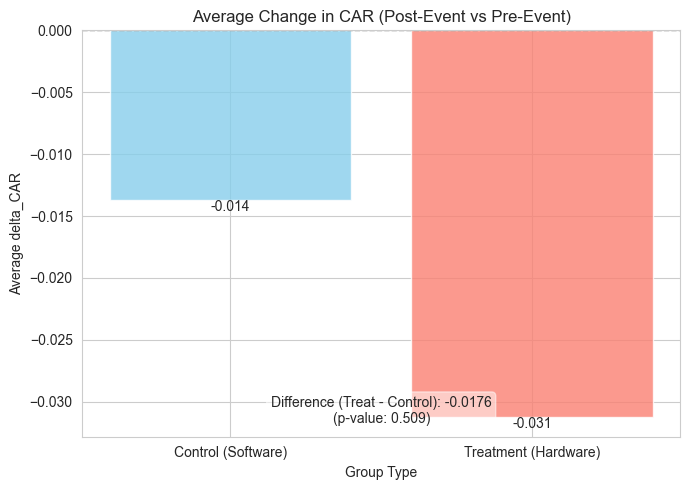

In [4]:
# Summary Bar Chart
avg_delta_car = cross_df.groupby("GroupType")["delta_CAR"].mean().reindex(['Control (Software)', 'Treatment (Hardware)'])
treatment_effect = model_cs_hc3.params.get("Treatment", float('nan')) # Use consistent model (e.g., HC3)
p_value = model_cs_hc3.pvalues.get("Treatment", float('nan'))

plt.figure(figsize=(7, 5)) # Slightly smaller figure maybe
bars = plt.bar(avg_delta_car.index, avg_delta_car.values, color=["skyblue", "salmon"], alpha=0.8)
plt.title("Average Change in CAR (Post-Event vs Pre-Event)")
plt.ylabel("Average delta_CAR")
plt.xlabel("Group Type")
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom' if yval >=0 else 'top', ha='center')
plot_min, plot_max = plt.gca().get_ylim()
text_y_position = plot_max * 0.9 if treatment_effect >= 0 else plot_min * 0.9
if not pd.isna(treatment_effect) and not pd.isna(p_value):
    plt.text(0.5, text_y_position,
             f"Difference (Treat - Control): {treatment_effect:.4f}\n(p-value: {p_value:.3f})",
             horizontalalignment='center', verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))
plt.tight_layout()
plt.show()


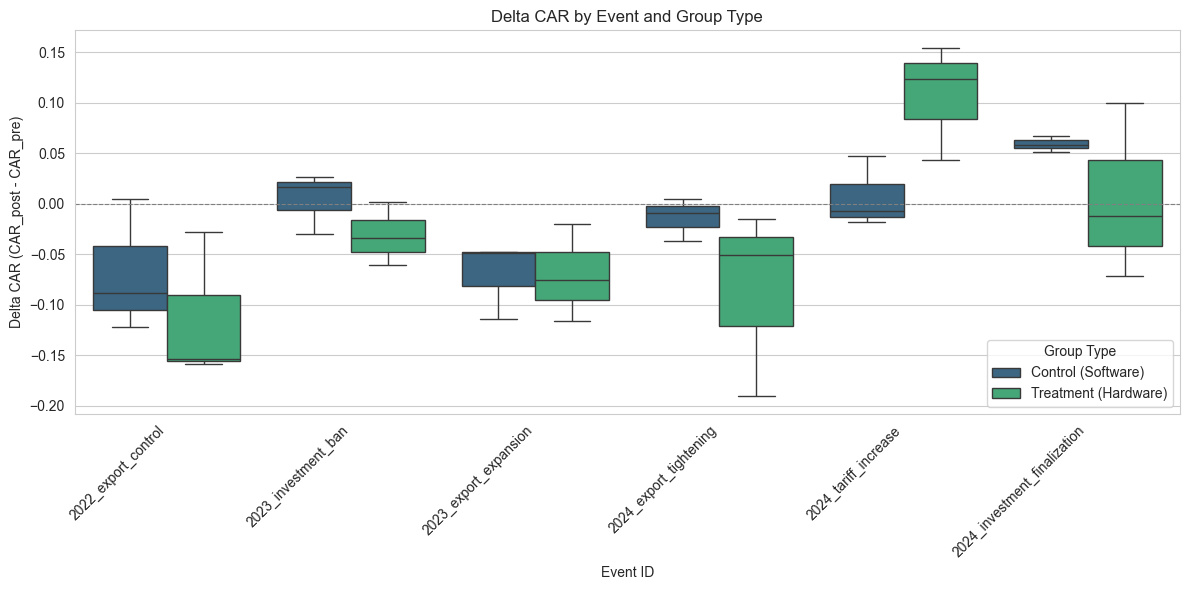

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='event_id', y='delta_CAR', hue='GroupType', data=cross_df, palette='viridis',
            hue_order=['Control (Software)', 'Treatment (Hardware)'])
plt.title('Delta CAR by Event and Group Type')
plt.xlabel('Event ID')
plt.ylabel('Delta CAR (CAR_post - CAR_pre)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Group Type', loc='lower right')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

Visual inspection of the change in CAR distributions, broken down by event and group type, reveals substantial event-specific heterogeneity. Market reactions differed significantly depending on the policy announcement. Notably, the relative performance between Hardware and Software firms was inconsistent across events. For example, Hardware firms showed a markedly more positive change in CAR during the 2024 tariff increase event compared to Software firms, while appearing to react more negatively during events like the 2022 export controls. This variability across events supports the improved model fit observed when including event fixed effects and helps explain the lack of a statistically significant average treatment effect in the primary DiD models, as event-specific differential impacts likely averaged out.